# Clustering for syndromic surveillance

In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Import and prepare data

In [3]:
features = pd.read_pickle("data/rwanda/features.pickle") # cleaned and prepared features as selected by domain experts with missing values
diagnoses = pd.read_pickle("data/rwanda/diagnoses.pickle")
villages = pd.read_pickle("data/rwanda/rw-village-coordinates.pickle")

# Perform clustering
Clustering approach selected based on the findings in `clustering-for-cdss-evaluation.ipynb`.

In [4]:
# imputate and numericalize based on domain and context
preprocessed_features = features.copy()

# rules for imputing and numericalisation
domain_based_data_preprocessing = {
        'patient_age': {"method":"median"}, # "method" refers to the NAN processing method
        'patient_gender': {"method":"median", "conversion":{"female": 1, "male": 0}},
        'PE212 - Respiratory rate (breaths/min) - 8469': {"method":"domain", "conversion":{np.nan : 14}},  # check wth doman if nan = 14 makes sense
        'S39 - Cough - 7817': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE18 - Chest indrawing - 7811': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S180 - How is the infant feeding currently? - 7516': {"method":"domain", "conversion":{np.nan : 0, 'Feeding well': 0, 'Not feeding well': 1, 'Not feeding at all': 2}},
        'S46 - Convulsions in present illness - 8355': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'BC - Axillary temperature - 7823 categorical': {"method":"domain", "conversion":{np.nan : 0, "< 38 °C": 0, ">= 38°C": 1}}, # check wth doman if nan = 0 makes sense
        'PE125 - Observation of movement - 8388': {"method":"domain", "conversion":{np.nan : 0, 'Movement without stimulation': 0, 'Movement only when stimulated': 1, 'No movement even when stimulated': 2}},
        'S96 - Unable to drink or breastfeed - 7871': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S157 - Vomiting everything - 8026': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'OS9 - Unconscious or Lethargic (Unusually sleepy) - 7378': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE63 - Stiff neck - 8391': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}}, 
        'PE19 - Stridor in calm child - 7812': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S42 - Duration of fever (days) - 7819 categorical': {"method":"domain", "conversion":{np.nan : 0, '< 4 days': 1, '>= 4 days < 7 days': 2, '>= 7 days < 14 days': 3, '>= 14 days': 4}},
        'S124 - Significant weight loss - 7539': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S118 - Significant hemoptysis (>1 episode) - 7941': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S176 - Cough duration (days) - 7731 categorical': {"method":"domain", "conversion":{np.nan : 0, "< 2 weeks": 1, ">= 2 weeks": 2}},
        'E46 - Recent close contact with somebody with TB - 7820': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE220 - Identifiable source of fever? - 8399': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'A55 - Urinary dipstick - 7648': {"method":"domain", "conversion":{np.nan : 0, "Pathologic": 1, "Normal": 0}},
        'PE134 - Measles rash and associated signs - 8386': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE109 - Scarlet fever rash - 8344': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE106 - Non specific viral rash - 7930': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'PE218 - Unexplained bleeding - 8107': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'S153 - Diarrhea (stools are looser or more watery than normal) - 7649': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'S98 - Number of loose or liquid stools over the past 24 hours - 7882 categorical': {"method":"domain", "conversion":{np.nan : 0, '<3': 1, '>=3': 2, '>=4': 3, '>=5': 4, '>=6': 5}},
        'S149 - Yellow appearing skin or eyes (jaundice) - 7630': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'PE191 - Jaundice - 8036': {"method":"domain", "conversion":{np.nan : 0, "Present": 1, "Absent": 0}},
        'S74 - Abnormal vaginal discharge - 8377': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
        'S81 - Urethral discharge - 7810': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}}, 
        'S79 - Genital lesion - 7867': {"method":"domain", "conversion":{np.nan : 0, "Yes": 1, "No": 0}},
                'BC7 - Weight for age (z-score) - 8434 categorical': {"method":"domain", "conversion":{np.nan : 0, "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2}}, # check wth doman if nan =0 makes sense
                'BC95 - Weight for height - 7451 categorical': {"method":"domain", "conversion":{np.nan : 0, "more than -2 z-score": 0, "-2 z-score": 1, "less than -2 z-score": 2}}, # check wth doman if nan = 0 makes sense
                "BC61 - MUAC for age z-score - 7839 categorical": {"method":"domain", "conversion":{np.nan : 0, '> - 2 z-score': 0, "-2 z-score": 1, '< -2 z-score': 2}},
        'malaria': {"method":"domain", "conversion":{np.nan : 0, "Positive": 1, "Negative": 0}},
                'fever without source: presumed bacterial infection': {"method":"domain", "conversion":{np.nan : 0, 'Accepted': 1, 'Manually added': 1, 'Rejected': 0,}}, # check wth doman if nan = 0 makes sense
                'fever without source: presumed viral illness': {"method":"domain", "conversion":{np.nan : 0, 'Accepted': 1, 'Manually added': 1, 'Rejected': 0,}}, # check wth doman if nan = 0 makes sense
        'suspicion of tuberculosis': {"method":"domain", "conversion":{np.nan : 0, "Accepted": 1, "Rejected": 0}}# check wth doman if nan = 0 makes sense
}

# impute nan and numericalise features based on domain knowledge
for feature in domain_based_data_preprocessing:
        if "conversion" in domain_based_data_preprocessing[feature]: 
                preprocessed_features[feature] = preprocessed_features[feature].replace(domain_based_data_preprocessing[feature]["conversion"])
        if domain_based_data_preprocessing[feature]["method"] == "median": 
                median=preprocessed_features[feature].median()
                preprocessed_features[feature] = preprocessed_features[feature].fillna(median)
        if domain_based_data_preprocessing[feature]["method"] == "mean": 
                mean=preprocessed_features[feature].mean()
                preprocessed_features[feature] = preprocessed_features[feature].fillna(mean)

# convert features to float 
preprocessed_features = preprocessed_features.astype(float)

# standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(preprocessed_features)
preprocessed_features = pd.DataFrame(scaled_features, columns=preprocessed_features.columns)

# check if there are no missing values anymore  
print("Number of missing values in features after preprocessing:", preprocessed_features.isna().sum().sum())

Number of missing values in features after preprocessing: 0


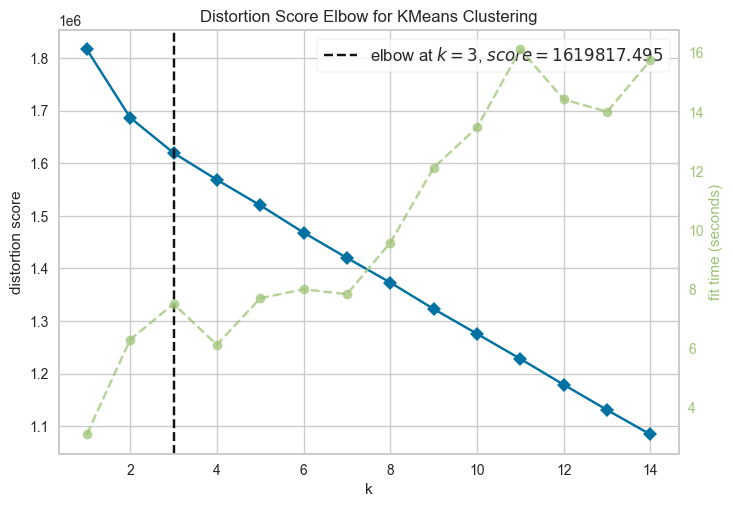

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# find k with elbow method
model = KMeans(n_init=100, random_state=1)
visualizer = KElbowVisualizer(model, k=(1,15))
visualizer.fit(preprocessed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=2).fit(preprocessed_features)
labeled_preprocessed_features = preprocessed_features.copy()
labeled_preprocessed_features["cluster"] = kmeans.labels_.astype("str")
labeled_features = features.copy()
labeled_features["cluster"] = kmeans.labels_.astype("str")

In [28]:
# store final clustering result as pickle for syndromic surveillance notebook and dashboard
labeled_preprocessed_features.to_pickle("data/rwanda/final_labeled_preprocessed_features")
labeled_preprocessed_features.to_pickle("data/dash/final_labeled_preprocessed_features")

# Evaluation
... through ...
- basic analysis, e. g.number of consultations per cluster
- feature distribution
- diagnoses distribution
- accuracy and shap values of lgbm classifier

## Basic analysis

## Feature distribution

In [48]:
# select feature whose dstribution per cluster you want to examine
feature=features.columns[31]

In [46]:
#show distribution of upper selected feature per cluster depending on data type of feature
def show_feature_distribution_per_cluster(feature):
    if "float" in str(labeled_features[feature].dtype) and len(labeled_features[feature].dropna().unique())>2: #if continues feature plot as boxplots
        fig = px.box(labeled_features, x="cluster", y=feature, title=f"Distribution of '{feature}' per cluster", labels={"cluster":"Cluster"})
    else:
        cluster_size=labeled_features.groupby("cluster").size().reset_index(name="cluster_size")
        feature_per_cluster=labeled_features.groupby(["cluster", feature], dropna=False).size().reset_index(name="feature_size")
        feature_per_cluster[feature] = feature_per_cluster[feature].astype(str)
        feature_per_cluster=feature_per_cluster.merge(cluster_size, on="cluster")
        feature_per_cluster["share_category"] = feature_per_cluster["feature_size"] / feature_per_cluster["cluster_size"]
        fig = px.bar(feature_per_cluster, x="cluster", y="share_category", color=feature, title=f"Distribution of '{feature}' per cluster", labels={"cluster":"Cluster", "share_category":"Cluster share", feature:"Categories"})
        fig.update_yaxes(range=[0, 1])
    return fig

In [49]:
show_feature_distribution_per_cluster(feature).show()

## Diagnosis distribution

In [11]:
diagnoses_per_cluster = diagnoses.copy()

# add cluster result to diagnoses
diagnoses_per_cluster["cluster"] = labeled_features["cluster"]
number_consultations_per_cluster = diagnoses_per_cluster.groupby("cluster").size().reset_index(name="number_consultations")
diagnoses_per_cluster = diagnoses_per_cluster.groupby("cluster").sum().reset_index()
diagnoses_per_cluster = diagnoses_per_cluster.merge(number_consultations_per_cluster, on="cluster")

number_diagnoses_per_cluster = pd.melt(
    diagnoses_per_cluster,
    id_vars=["cluster"], 
    value_vars=diagnoses_per_cluster.columns.drop(["cluster", "number_consultations"]),
    var_name="diagnosis", value_name="number_consultations"
)

for d in diagnoses.columns:
    diagnoses_per_cluster[d] = diagnoses_per_cluster[d] / diagnoses_per_cluster["number_consultations"]

share_diagnoses_per_cluster = pd.melt(
    diagnoses_per_cluster,
    id_vars=["cluster"], 
    value_vars=diagnoses_per_cluster.columns.drop(["cluster", "number_consultations"]),
    var_name="diagnosis", value_name="share_number_consultations"
)
share_diagnoses_per_cluster["share_number_consultations"] = np.round(share_diagnoses_per_cluster["share_number_consultations"], 4)

clusters = range(int(diagnoses_per_cluster["cluster"].max())+1)

# print diagnoses and the clusters if they are not present in every cluster
diagnoses_cluster_appearance = number_diagnoses_per_cluster.groupby("diagnosis").size().reset_index(name="number_cluster_appearance")
print("Diagnoses determining clusters:", diagnoses_cluster_appearance[diagnoses_cluster_appearance["number_cluster_appearance"]<len(clusters)])

# plot diagnoses distribution
fig_diagnoses = px.bar(
    share_diagnoses_per_cluster, 
    x="cluster", 
    y="share_number_consultations", 
    animation_frame="diagnosis",
    barmode="group", 
    text="share_number_consultations",
    title=f"Number of consultations with respective diagnosis per cluster",
    labels={"share_number_consultations": "Share number of consultations", "diagnosis":"Diagnosis", "cluster":"Cluster"}  
)
fig_diagnoses.update_yaxes(range=[0, 1])
fig_diagnoses.show()

C:\Users\sidla\AppData\Local\Temp\ipykernel_20332\556850888.py:9: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



Diagnoses determining clusters: Empty DataFrame
Columns: [diagnosis, number_cluster_appearance]
Index: []


## Accuracy and SHAP values of LightGBM classifier

In [22]:
# build lgbm classifier with diagnoses as features to see how well they explain the labels
import lightgbm as lgb # was chosen as mutlinominal regression did not converge and because it is later used due to its advantage of being able to take in categorical values
from sklearn.model_selection import cross_val_score
import shap
import re

# function for evaluate cluster result based on accuracy and shap values of lgbm classifier
def evaluate_with_lgbm_classifier(data, labels, title, path):
    # rename columns so that lgbm can read them
    data.columns = [re.sub(r'(>)|(<)', lambda m: 'higher' if m.group(1) else 'lower', c) for c in data.columns] # essental to ensure that columns are stll dstnct after next lne of code
    data.columns = [re.sub('[^A-Za-z0-9_]+', ' ', c) for c in data.columns]

    # check how good the clusters are: the higher F1 the better
    clf = lgb.LGBMClassifier() #colsample_by_tree=0.8
    cv_scores = cross_val_score(clf, data, labels, scoring='f1_weighted')
    mean_cv_scores = np.mean(cv_scores)
    print(f"CV F1 score of classifier is {mean_cv_scores}")

    # check how features are used to explain the label
    clf.fit(data, labels) # fit model

    #SHAP values to determine how features are used for classification
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values, data, plot_type="bar", plot_size=(15, 10), show=False)
    plt.title(title)
    plt.savefig(path)
    plt.show()

    return mean_cv_scores

In [23]:
labels=labeled_features["cluster"]

# to gather classifier results
accuracy_scores = []

### Feature based classifier

CV F1 score of classifier is 0.9983884459827426


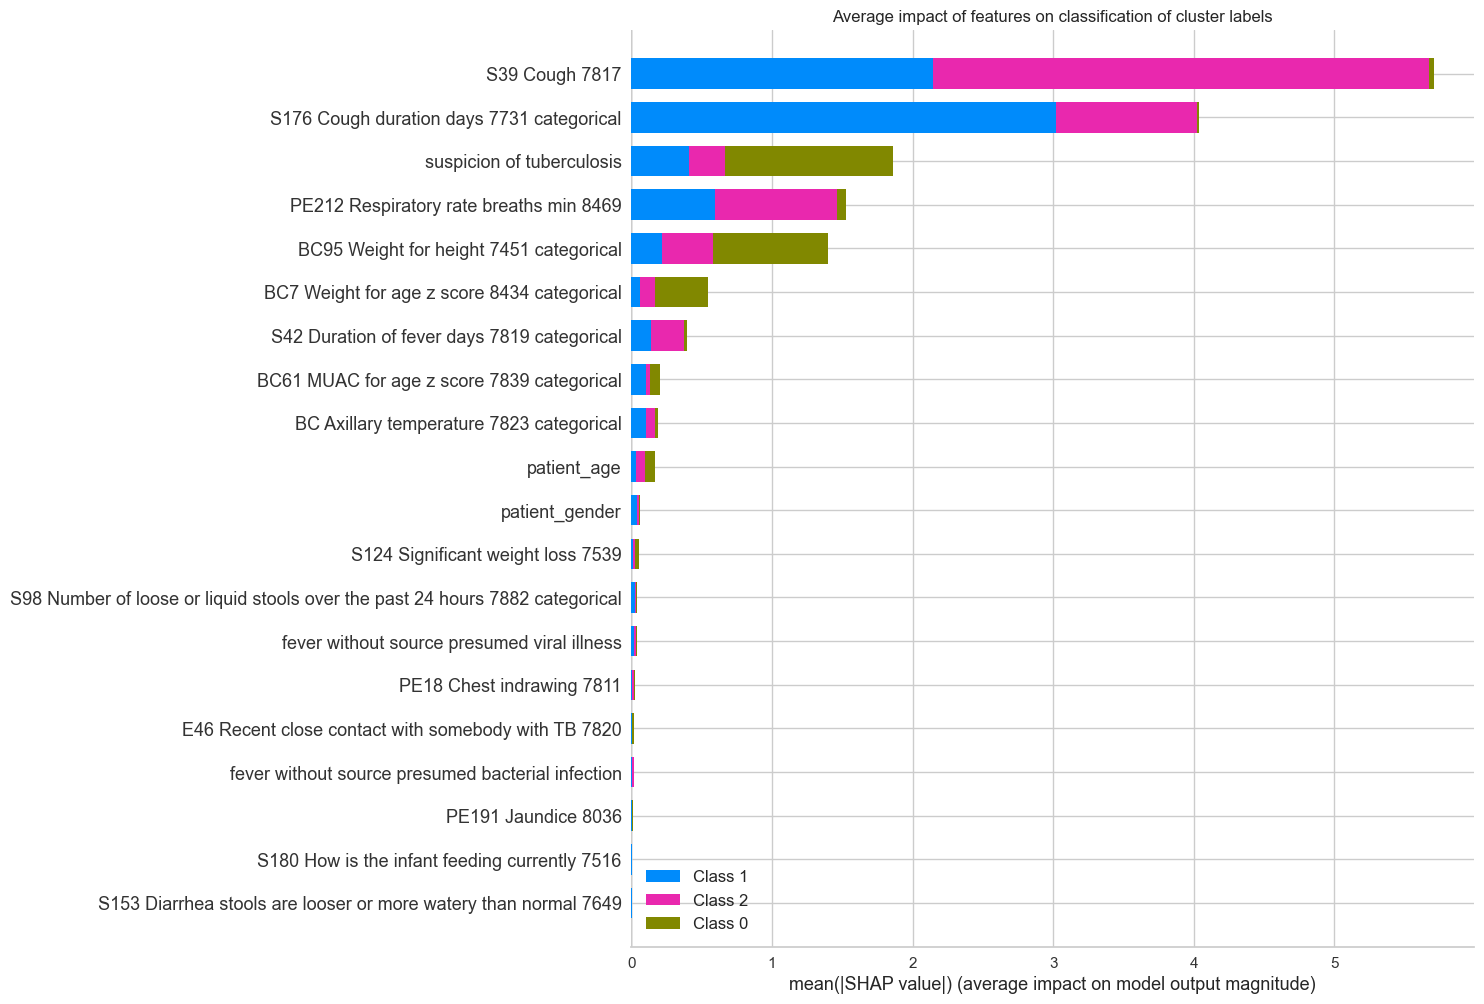

In [24]:
accuracy_scores.append({
    "classifier": "Feature based classifier",
    "accuracy": evaluate_with_lgbm_classifier(
        labeled_preprocessed_features.drop(["cluster"], axis=1), 
        labels, 
        f"Average impact of features on classification of cluster labels",
        "plots/syndromic_surveillance/clustering_evaluation/shap_values_feature_based_classifier"
    )
})

### Diagnosis based classifier

CV F1 score of classifier is 0.8454553792621645


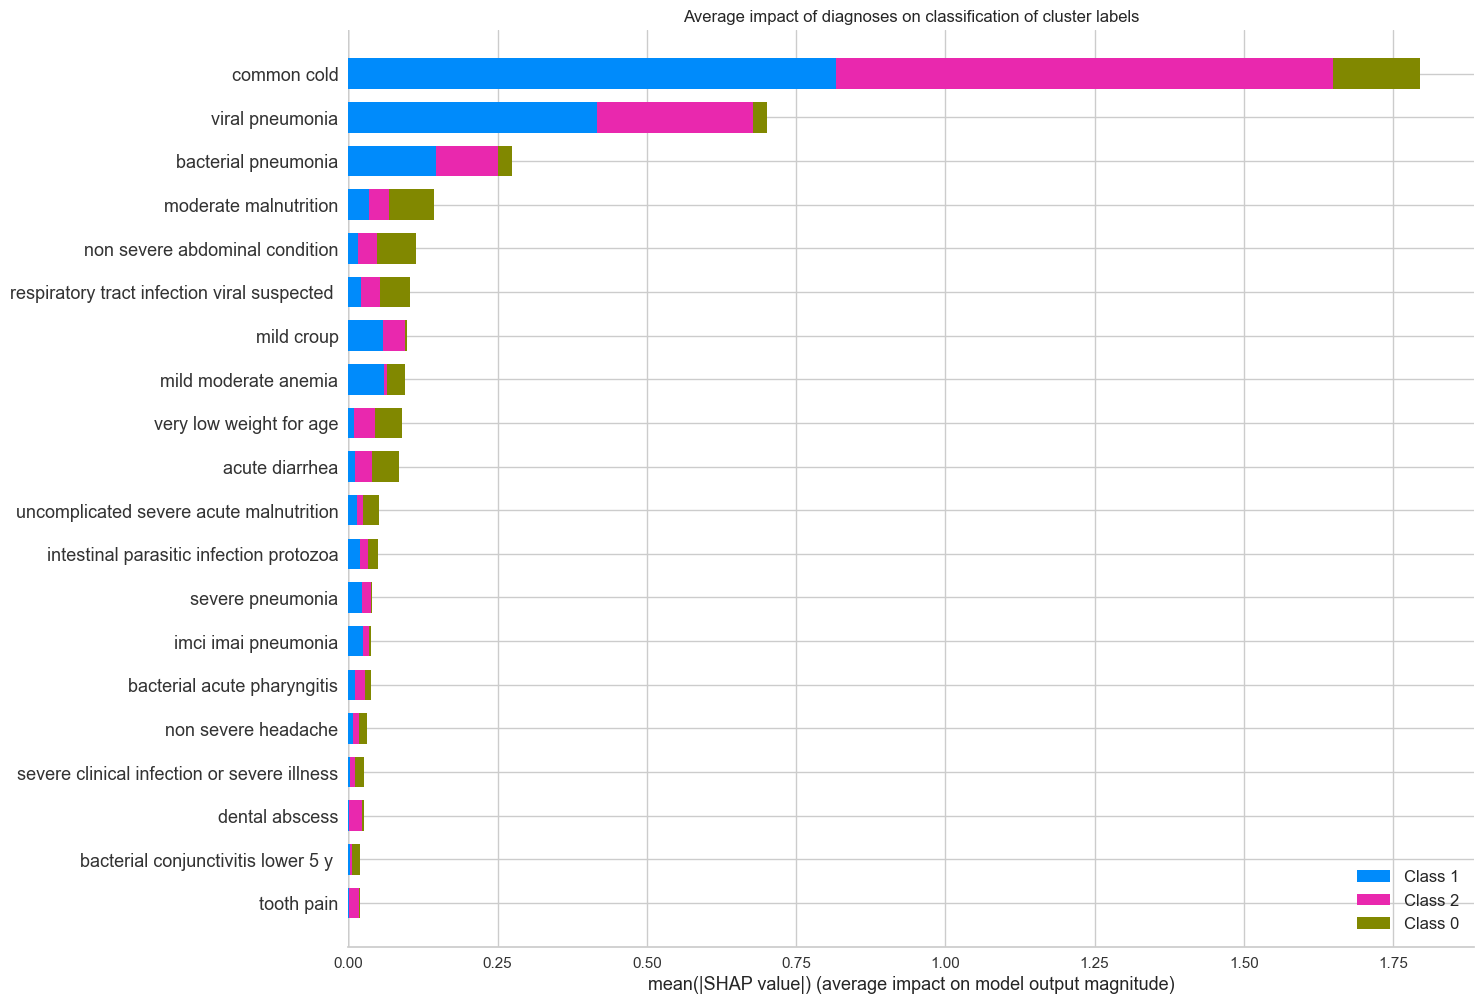

In [25]:
accuracy_scores.append({
    "classifier": "Diagnosis based classifier",
    "accuracy": evaluate_with_lgbm_classifier(
        diagnoses, 
        labels, 
        f"Average impact of diagnoses on classification of cluster labels",
        "plots/syndromic_surveillance/clustering_evaluation/shap_values_diagnosis_based_classifier"
    )
})

### Missingness based classifier

CV F1 score of classifier is 0.8910630980354215


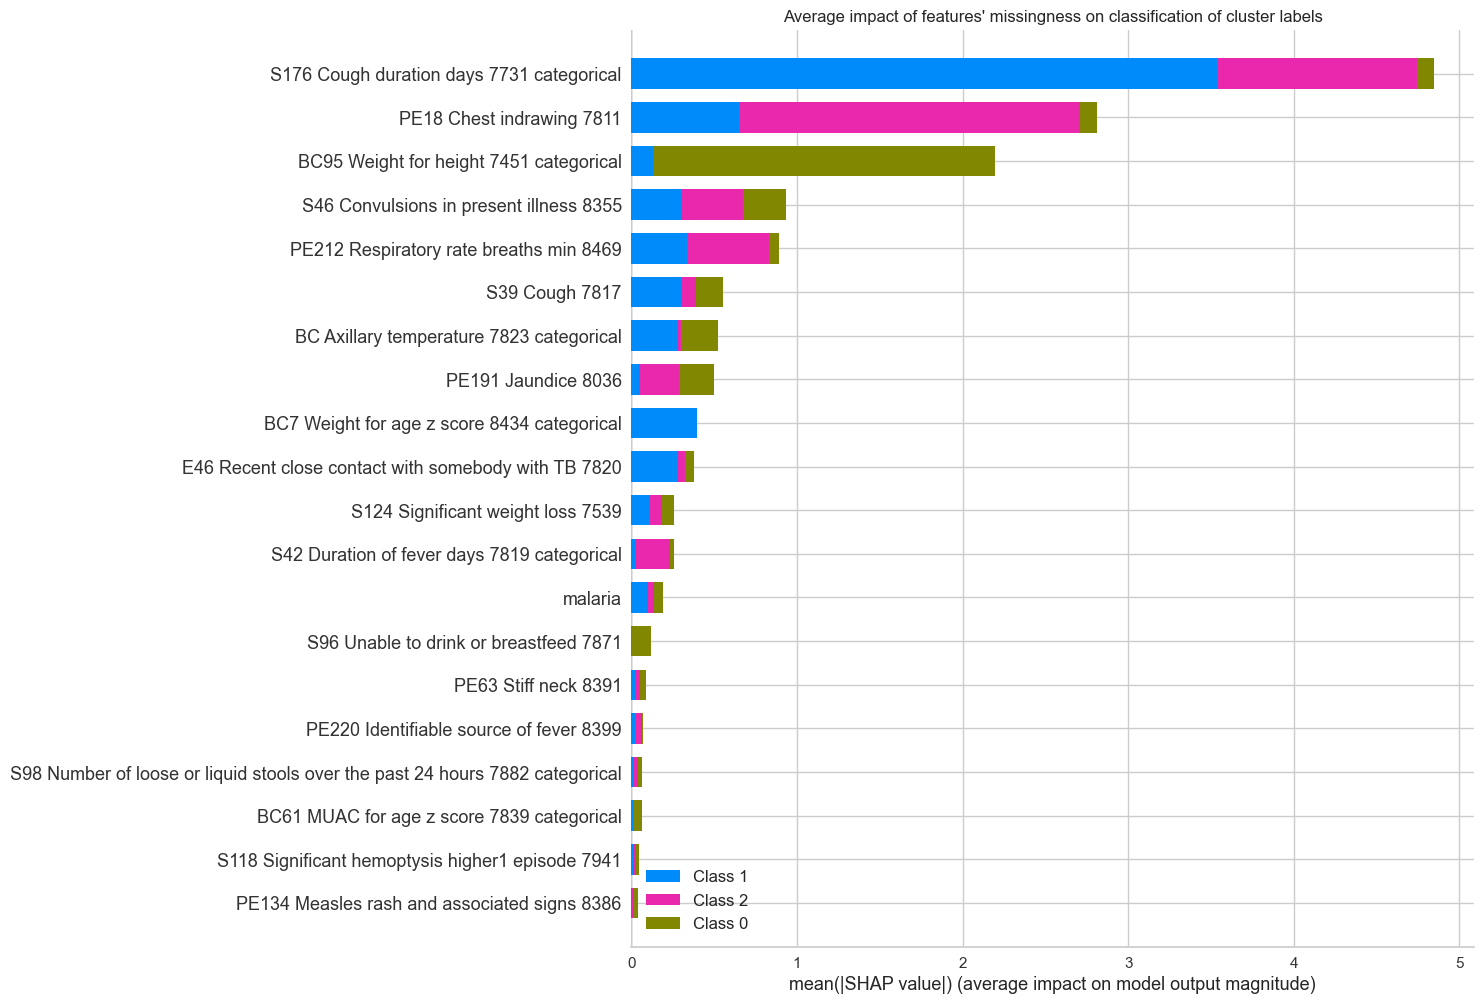

In [26]:
accuracy_scores.append({
    "classifier": "Missingness based classifier",
    "accuracy": evaluate_with_lgbm_classifier(
        features.isna()*1, 
        labels, 
        f"Average impact of features' missingness on classification of cluster labels",
        "plots/syndromic_surveillance/clustering_evaluation/shap_values_missingness_based_classifier"
    )
})

### Summary classifiers

In [27]:
summary_classifiers = pd.DataFrame(accuracy_scores)
summary_classifiers["accuracy"] = np.round(summary_classifiers["accuracy"], 4)
fig_summary_classifiers_accuracy = px.bar(summary_classifiers, 
    x="classifier", 
    y="accuracy", 
    text="accuracy",
    title="Overview: accuracy of classifiers for clustering label",
    labels={"accuracy": "Cross-validated F1 score", "classifier" : "Classifier"}
)
fig_summary_classifiers_accuracy.update_layout(yaxis_range=[0, 1])
fig_summary_classifiers_accuracy.write_image("plots/syndromic_surveillance/clustering_evaluation/summary_classifiers_accuracy.png")
fig_summary_classifiers_accuracy.show()